# Load

In [1]:
import io
import logging
import math
import sys
import pandas as pd
from typing import Tuple, get_args
from py_ballisticcalc import Ammo, Atmo, Weapon, Shot, Calculator, HitResult
from py_ballisticcalc import RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG7, logger, loadMetricUnits
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire
from py_ballisticcalc.unit import *
from py_ballisticcalc.interface import _EngineLoader
logger.setLevel(logging.WARNING)
print("\nAvailable engines: " + str(sorted([e.name for e in _EngineLoader.iter_engines()])))
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
PreferredUnits.distance = Distance.Meter


Available engines: ['cythonized_euler_engine', 'cythonized_rk4_engine', 'euler_engine', 'rk4_engine', 'scipy_engine', 'verlet_engine']


## Reference Calculator

This _reference calculator_ will determine the "correct" trajectory against which the error of all others will be measured.


In [2]:
ref_config = SciPyEngineConfigDict(
    relative_tolerance=1e-12,
    absolute_tolerance=1e-12,
    integration_method="LSODA",
)
ref_calc = Calculator(ref_config, engine='scipy_engine')

# Scenarios

## 2km flat-fire trajectory

A typical 7.62mm bullet launched at an elevation (60mils, about 3.375 degrees) sufficient to reach approximately 2km.  We use the reference calculator to compute the trajectory.

,time,distance,velocity,mach,height,angle,density_ratio,drag,energy,flag
1,0.001 s,0.7 m,800 m/s,2.35 mach,-0.0 m,3.3744 °,1.00002e+00,2.635e-04,3196 J,ZERO_UP
10,1.564 s,814.0 m,340 m/s,1.00 mach,38.8 m,1.5851 °,9.96307e-01,3.605e-04,579 J,MACH
13,2.440 s,1086.3 m,292 m/s,0.86 mach,42.7 m,-0.0000 °,9.95929e-01,1.255e-04,426 J,APEX
22,5.534 s,1861.7 m,219 m/s,0.64 mach,0.0 m,-6.9538 °,1.00002e+00,1.134e-04,240 J,ZERO_DOWN


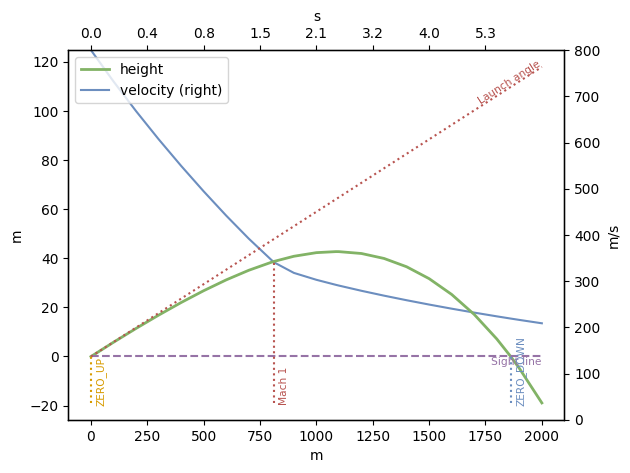

In [3]:
dm = DragModel(0.22, TableG7, Weight.Gram(10), Distance.Centimeter(7.62), Distance.Centimeter(3.0))
ammo = Ammo(dm, Velocity.MPS(800))
weapon = Weapon(sight_height=Distance.Centimeter(4), twist=Distance.Centimeter(30), zero_elevation=Angular.Mil(60.0))
baseline_shot = Shot(weapon=weapon, ammo=ammo, atmo=Atmo.icao())
range = Distance.Meter(2000)
range_step = Distance.Meter(100)
reference_trajectory = ref_calc.fire(shot=baseline_shot, trajectory_range=range, trajectory_step=range_step, extra_data=True)
reference_trajectory.plot()
ref = reference_trajectory.dataframe(True).drop(columns=['slant_height', 'drop_adj', 'windage', 'windage_adj', 'slant_distance', 'ogw'])
ref[ref.flag != "RANGE"]

### Define error

We will take the ZERO_DOWN (return-to-zero) row as our reference point for assessing the error in other engines.

In [4]:
reference_row = reference_trajectory.flag(TrajFlag.ZERO_DOWN)
reference_distance = reference_row.distance
reference_distance_meter = reference_distance >> Distance.Meter
def check_error(hit: HitResult, output: bool = False) -> float:
    """Error is vertical distance from zero at the reference distance."""
    chkpt = hit.get_at_distance(reference_distance)
    if chkpt is not None:
        chk_x = chkpt.distance >> Distance.Meter
        chk_h = chkpt.height >> Distance.Meter
        chk_err = math.sqrt((chk_x-reference_distance_meter)**2 + chk_h**2)
        if output:
            print(f'At {chkpt.time}s: ({chk_x}, {chk_h})m ==> Error = {chk_err:.8f}m')
        return chk_err
    return float('inf')

summary = []

## SciPy

In [5]:
def scipy_chk(timeit: bool = False, **kwargs):
    config = SciPyEngineConfigDict(
        **kwargs,
    )
    calc = Calculator(config, engine='scipy_engine')
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals
logger.setLevel(logging.WARNING)
# Run with default tolerance:
err, count, speed = scipy_chk(timeit=True, integration_method="LSODA")
print(f'Error={err:.8f}m.  Integration steps: {count}.  Speed: {speed:.5f}s')

62.3 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Error=0.00016476m.  Integration steps: 1776.  Speed: 0.06231s


### Integration Methods

Here's a quick look at each of the integration methods listed in the SciPyIntegrationEngine, using its default error tolerance settings.

In [6]:
from py_ballisticcalc.engines.scipy_engine import INTEGRATION_METHOD
method_summary = []
for method in get_args(INTEGRATION_METHOD):
    err, count, speed = scipy_chk(timeit=True, integration_method=method)
    method_summary.append(('SciPy', method, err, count, speed))
pd.DataFrame(method_summary, columns=['Engine', 'Setting', 'Error (m)', 'Integration Steps', 'Speed (s)']).set_index('Setting').sort_values(by='Error (m)', ascending=True)

59.8 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
40 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
123 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
353 ms ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
195 ms ± 8.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
68.7 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Engine,Error (m),Integration Steps,Speed (s)
Setting,,,,
Radau,SciPy,0.000003,4591,0.352530
BDF,SciPy,0.000036,1965,0.194772
RK23,SciPy,0.000076,1583,0.059769
LSODA,SciPy,0.000165,1776,0.068729
DOP853,SciPy,0.000852,5402,0.122707
RK45,SciPy,0.001351,1118,0.039986


### Tolerance

SciPy allows us to specify both "absolute" and "relative" error tolerance.  The meaning of the two terms and their interaction isn't always intuitive, so let's see what happens as we vary each while holding out the other term.  We'll do this for both the LSODA and RK45 methods.

#### LSODA

In [7]:
tol_tests = []
method = 'LSODA'
# Run with rtol as limiting factor
rtol = 1.
atol = 1e-13
while rtol > 1e-8:
    rtol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
# Run with atol as limiting factor
atol = 1.
rtol = 1e-13
while atol > 1e-8:
    atol /= 10.0
    err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
    tol_tests.append((method, atol, rtol, err, count))
display(
    pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps'])
      .sort_values(by='Error (m)', ascending=False)
      .style.format({'Absolute Tolerance': '{:.0e}', 'Relative Tolerance': '{:.0e}', 'Error (m)': '{:.11f}'}))

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
0,LSODA,1e-13,1e-01,2.00897324879,100
1,LSODA,1e-13,1e-02,0.78836705253,121
3,LSODA,1e-13,1e-04,0.02085849732,162
9,LSODA,1e-01,1e-13,0.01841224363,82
10,LSODA,1e-02,1e-13,0.00539150910,171
5,LSODA,1e-13,1e-06,0.00227701489,496
11,LSODA,1e-03,1e-13,0.00207619842,458
4,LSODA,1e-13,1e-05,0.00130312391,263
2,LSODA,1e-13,1e-03,0.00087850598,155
6,LSODA,1e-13,1e-07,0.00079173517,1041


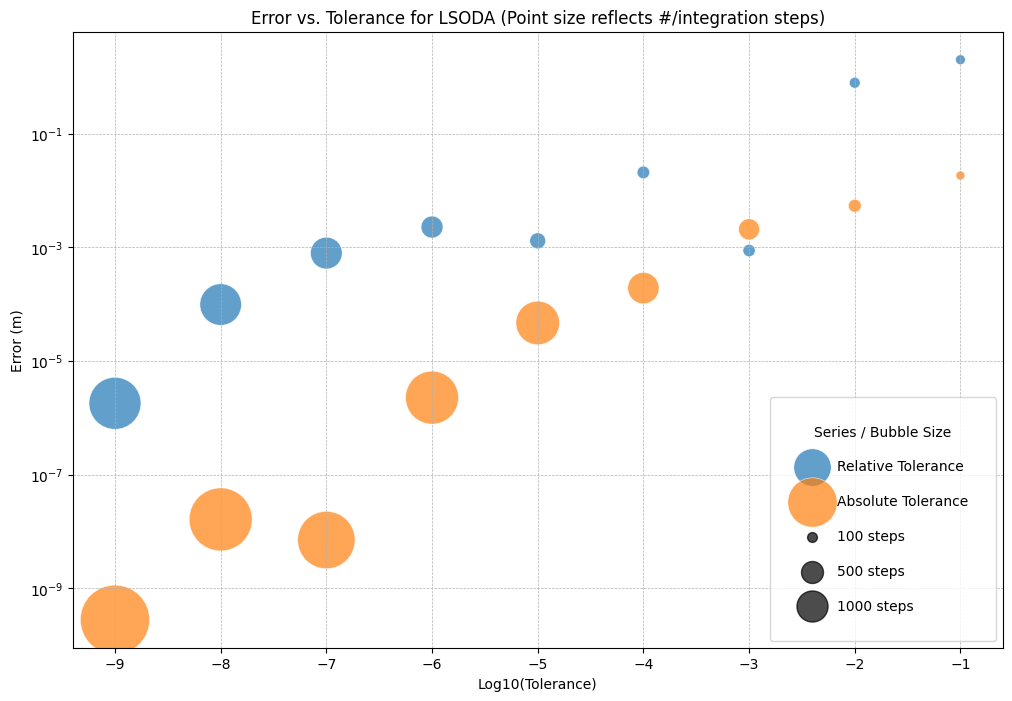

In [8]:
import matplotlib.pyplot as plt
import numpy as np
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps'])
# Separate the two series of data
atol_fixed = df_tol[df_tol['Absolute Tolerance'] == 1e-13].copy()
rtol_fixed = df_tol[df_tol['Relative Tolerance'] == 1e-13].copy()

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the series where Absolute Tolerance is fixed
ax.scatter(
    np.log10(atol_fixed['Relative Tolerance']),
    atol_fixed['Error (m)'],
    s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Relative Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
# Plot the series where Relative Tolerance is fixed
ax.scatter(
    np.log10(rtol_fixed['Absolute Tolerance']),
    rtol_fixed['Error (m)'],
    s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
    label='Absolute Tolerance',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance for LSODA (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2, loc='lower right')
#plt.savefig('ErrorTolerance.svg', bbox_inches='tight')
plt.show()

#### RK45

In [9]:
method = 'RK45'
# Run with rtol as limiting factor
rtol = 1e-1
atol = 1e-13
while rtol > 1e-10:
    rtol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {rtol=}")
        continue
# Run with atol as limiting factor
atol = 1e-1
rtol = 1e-13
while atol > 1e-10:
    atol /= 10.0
    try:
        err, count = scipy_chk(integration_method=method, relative_tolerance=rtol, absolute_tolerance=atol)
        tol_tests.append((method, atol, rtol, err, count))
    except ArithmeticError as e:
        print(f"Failed to reach distance with {atol=}")
        continue
df_tol = pd.DataFrame(tol_tests, columns=['Method', 'Absolute Tolerance', 'Relative Tolerance', 'Error (m)', 'Integration Steps']).sort_values(by='Error (m)', ascending=False)
display(df_tol[df_tol['Method'] == 'RK45'].sort_values(by='Error (m)', ascending=False)
      .style.format({'Absolute Tolerance': '{:.0e}', 'Relative Tolerance': '{:.0e}', 'Error (m)': '{:.11f}'}))

,Method,Absolute Tolerance,Relative Tolerance,Error (m),Integration Steps
18,RK45,1e-13,1e-02,4.80902599635,110
19,RK45,1e-13,1e-03,1.42335689541,116
20,RK45,1e-13,1e-04,0.13834681911,134
21,RK45,1e-13,1e-05,0.05931755799,170
29,RK45,1e-03,1e-13,0.02401295393,176
28,RK45,1e-02,1e-13,0.02320768712,110
22,RK45,1e-13,1e-06,0.01041117103,218
23,RK45,1e-13,1e-07,0.00970797018,428
30,RK45,1e-04,1e-13,0.00335060298,512
24,RK45,1e-13,1e-08,0.00077076278,1364


#### Chart

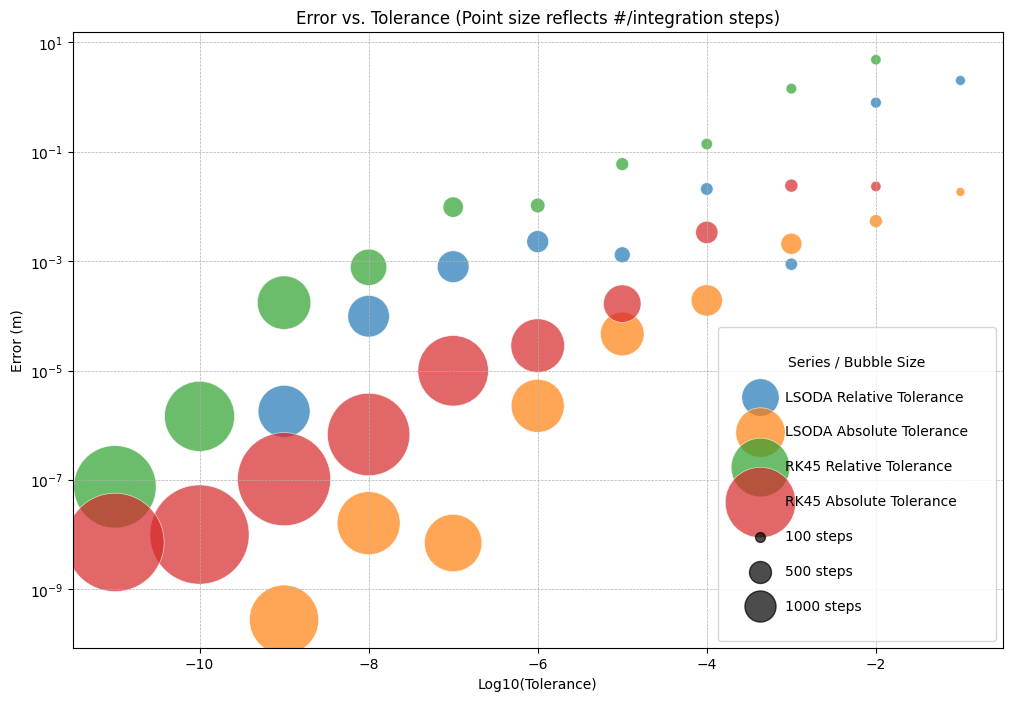

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))
for method in ['LSODA', 'RK45']:
    atol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Absolute Tolerance'] == 1e-13)].copy()
    rtol_fixed = df_tol[(df_tol.Method == method) & (df_tol['Relative Tolerance'] == 1e-13)].copy()
    # Plot the series where Absolute Tolerance is fixed
    ax.scatter(
        np.log10(atol_fixed['Relative Tolerance']),
        atol_fixed['Error (m)'],
        s=atol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Relative Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
    # Plot the series where Relative Tolerance is fixed
    ax.scatter(
        np.log10(rtol_fixed['Absolute Tolerance']),
        rtol_fixed['Error (m)'],
        s=rtol_fixed['Integration Steps'] * 0.5,  # Scale size for better visibility
        label=method + ' Absolute Tolerance',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
ax.set_xlabel('Log10(Tolerance)')
ax.set_ylabel('Error (m)')
ax.set_title('Error vs. Tolerance (Point size reflects #/integration steps)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log') # Use a log scale for error to see the full range
# Add a legend for bubble sizes
for steps in [100, 500, 1000]:
    ax.scatter([], [], s=steps * 0.5, c='k', alpha=0.7, label=f'{steps} steps')
ax.legend(title='Series / Bubble Size', scatterpoints=1, labelspacing=1.5, borderpad=2)
plt.show()

### Chosen Methods

For purposes of charting against the non-SciPy methods, we'll vary these two SciPy methods over a range of tolerance settings that give monotonically increasing error with speed.

In [11]:
method = 'RK45'
atol = 1e-10
while atol < 1.0:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, absolute_tolerance=atol, relative_tolerance=1e-12)
    summary.append(('SciPy '+method, atol, err, count, speed))
    atol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'atol', 'Error (m)', 'Integration Steps', 'Speed (s)'])
display(df[df.Engine == 'SciPy '+method].style.format({'atol': '{:.0e}', 'Error (m)': '{:.10f}'}))

299 ms ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
199 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
169 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
136 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.4 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.6 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.4 ms ± 343 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.63 ms ± 50.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.62 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.7 ms ± 35.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,atol,Error (m),Integration Steps,Speed (s)
0,SciPy RK45,1e-10,0.0000000151,8702,0.299046
1,SciPy RK45,1e-09,0.0000001255,7520,0.198652
2,SciPy RK45,1e-08,0.0000002763,6722,0.169317
3,SciPy RK45,1e-07,0.0000020576,5156,0.135883
4,SciPy RK45,1e-06,0.0001278431,3080,0.089423
5,SciPy RK45,1e-05,0.0001206575,1448,0.038640
6,SciPy RK45,1e-04,0.0033475213,512,0.014426
7,SciPy RK45,1e-03,0.0240124628,176,0.005635
8,SciPy RK45,1e-02,0.0232075855,110,0.004622
9,SciPy RK45,1e-01,0.0297321427,68,0.002697


In [12]:
method = 'LSODA'
atol = 1e-10
while atol < 1.0:
    err, count, speed = scipy_chk(timeit=True, integration_method=method, absolute_tolerance=atol, relative_tolerance=1e-12)
    summary.append(('SciPy '+method, atol, err, count, speed))
    atol *= 10.0
df = pd.DataFrame(summary, columns=['Engine', 'atol', 'Error (m)', 'Integration Steps', 'Speed (s)'])
display(df[df.Engine == 'SciPy '+method].style.format({'atol': '{:.0e}', 'Error (m)': '{:.10f}'}))

192 ms ± 995 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
192 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 673 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
106 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
66.3 ms ± 882 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.3 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.8 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.78 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.88 ms ± 87.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


,Engine,atol,Error (m),Integration Steps,Speed (s)
10,SciPy LSODA,1e-10,0.0000000019,4836,0.191704
11,SciPy LSODA,1e-09,0.0000000029,4631,0.192327
12,SciPy LSODA,1e-08,0.0000000075,4179,0.162791
13,SciPy LSODA,1e-07,0.0000000195,3492,0.128291
14,SciPy LSODA,1e-06,0.0000005716,2825,0.106481
15,SciPy LSODA,1e-05,0.0000220671,1906,0.066297
16,SciPy LSODA,1e-04,0.0002787119,992,0.043315
17,SciPy LSODA,1e-03,0.0031272629,425,0.016802
18,SciPy LSODA,1e-02,0.0018361749,174,0.008785
19,SciPy LSODA,1e-01,0.0171775568,82,0.003883


## Other engines

In [13]:
def chk_engine(engine_name: str, timeit: bool = False, step_multiplier: float = 1.0):
    config = BaseEngineConfigDict(
        cStepMultiplier=step_multiplier,
    )
    calc = Calculator(config, engine=engine_name)
    hit, e = must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
    err = check_error(hit, False)
    evals = calc.integration_step_count
    if timeit:
        speed = %timeit -o must_fire(calc, shot=baseline_shot, trajectory_range=range, trajectory_step=reference_distance)
        return err, evals, speed.average
    return err, evals

## RK4

The Runge-Kutta 4th-order solver essentially evaluates 4 points per integration step.  To facilitate comparison with the other engines we'll set its base time step to 1ms.

In [14]:
from py_ballisticcalc.engines import RK4IntegrationEngine
rk_time_step = RK4IntegrationEngine.DEFAULT_TIME_STEP = 0.001

In [15]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('rk4_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('RK4', multiplier*rk_time_step, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Step (s)', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'RK4']

10.9 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.15 s ± 62.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
537 ms ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
90 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.3 ms ± 483 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.63 ms ± 110 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
980 μs ± 234 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Step (s),Error (m),Integration Steps,Speed (s)
20,RK4,0.00004,0.000123,347848,10.854290
21,RK4,0.00020,0.000605,69570,2.152400
22,RK4,0.00100,0.002704,13914,0.536611
23,RK4,0.00500,0.014660,2783,0.090032
24,RK4,0.02500,0.067012,557,0.017320
25,RK4,0.12500,0.346481,112,0.003627
26,RK4,0.62500,2.987859,23,0.000980


## Verlet

Our velocity Verlet solver has a base time step of 1ms:

In [16]:
from py_ballisticcalc.engines import VelocityVerletIntegrationEngine
verlet_time_step = VelocityVerletIntegrationEngine.DEFAULT_TIME_STEP

In [17]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 500.0:
    err, count, speed = chk_engine('verlet_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Verlet', multiplier*verlet_time_step, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Step (s)', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Verlet']

4.47 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
879 ms ± 57.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
175 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.7 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.51 ms ± 529 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.56 ms ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Step (s),Error (m),Integration Steps,Speed (s)
27,Verlet,0.00004,0.005741,347846,4.467510
28,Verlet,0.00020,0.028685,69568,0.878940
29,Verlet,0.00100,0.143862,13912,0.174871
30,Verlet,0.00500,0.720899,2781,0.043736
31,Verlet,0.02500,3.698342,555,0.007510
32,Verlet,0.12500,21.619532,109,0.001565


## Euler

Our Euler integrator uses a base "step" of 0.5ft, which it then converts to a time step by dividing by `max(1.0, velocity)` (where velocity is in fps).  This makes the algorithm to take smaller steps when things are changing more quickly, which should produce lower error for the same total number of steps than it would if step size were held constant.

In [18]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    err, count, speed = chk_engine('euler_engine', timeit=True, step_multiplier=multiplier)
    summary.append(('Euler', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Euler']

4.93 s ± 94.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
977 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
290 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
39.7 ms ± 892 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.26 ms ± 2.66 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.77 ms ± 33.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
609 μs ± 201 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
33,Euler,0.04,0.002065,545834,4.931240
34,Euler,0.20,0.010319,109166,0.976583
35,Euler,1.00,0.051491,21833,0.289522
36,Euler,5.00,0.258586,4366,0.039727
37,Euler,25.00,1.296182,873,0.009258
38,Euler,125.00,6.662502,174,0.001765
39,Euler,625.00,37.926920,34,0.000609


## Euler constant step

Here we monkey-patch the `EulerIntegrationEngine` to use a constant time step to see if that has any effect on performance.  (It does not.)

In [19]:
from py_ballisticcalc.engines.euler import EulerIntegrationEngine
def time_step(self, base_step: float, velocity: float) -> float:
    return base_step / 500.0  # Set a constant time step of 1ms for Euler engine
EulerIntegrationEngine.time_step = time_step
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 500.0:
    err, count, speed = chk_engine('euler_engine', step_multiplier=multiplier, timeit=True)
    summary.append(('Euler const', multiplier*0.001, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Step (s)', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'Euler const']

3.1 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
699 ms ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
123 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24.7 ms ± 529 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.9 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.17 ms ± 30.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


,Engine,Step (s),Error (m),Integration Steps,Speed (s)
40,Euler const,0.00004,0.005773,347846,3.099126
41,Euler const,0.00020,0.028739,69568,0.699337
42,Euler const,0.00100,0.144473,13912,0.122625
43,Euler const,0.00500,0.723063,2781,0.024713
44,Euler const,0.02500,3.669263,555,0.006902
45,Euler const,0.12500,19.707921,110,0.001173


## RK4 Compiled

In [20]:
step = 5.0
multiplier = 1.0/step**2
while multiplier <= 1000.0:
    # To get same step as other engines without recompiling, check the base step size in rk4_engine.pyx
    err, count, speed = chk_engine('cythonized_rk4_engine', timeit=True, step_multiplier=multiplier*(2.0/3.0))
    summary.append(('RK4 Cython', multiplier, err, count, speed))
    multiplier *= step
df = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed (s)'])
df[df.Engine == 'RK4 Cython']

56.2 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11 ms ± 46.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.28 ms ± 32.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
556 μs ± 23.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
183 μs ± 5.05 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
107 μs ± 727 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
91.9 μs ± 608 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


,Engine,Multiplier,Error (m),Integration Steps,Speed (s)
46,RK4 Cython,0.04,0.000126,347848,0.056213
47,RK4 Cython,0.20,0.000609,69570,0.010968
48,RK4 Cython,1.00,0.002707,13914,0.002283
49,RK4 Cython,5.00,0.014663,2783,0.000556
50,RK4 Cython,25.00,0.067015,557,0.000183
51,RK4 Cython,125.00,0.346484,112,0.000107
52,RK4 Cython,625.00,2.987861,23,0.000092


# Summary

The following chart shows that the highly adaptive SciPy solvers are in a class of their own: They produce the smallest errors, and can do so with an order of magnitude less compute.  Certainly part of this is thanks to their compiled back-end.  The compiled version of our RK4 solver is – despite a constant time step – even faster, and with the smallest multiplier setting its error is under 1 millimeter at almost 2km.

The poor showing by the velocity Verlet engine is striking but not unexpected: It is a second-order integrator, but one of its notable design advantages is conservation of energy. However, a ballistic trajectory with air resistance is a _dissipative_ system: The drag force varies with velocity, and this breaks the time-reversibility that the Verlet formulas were designed to exploit.  The result, as we see here, is that the Verlet's performance is reduced to that of the simpler, first-order Euler method.

## Chart

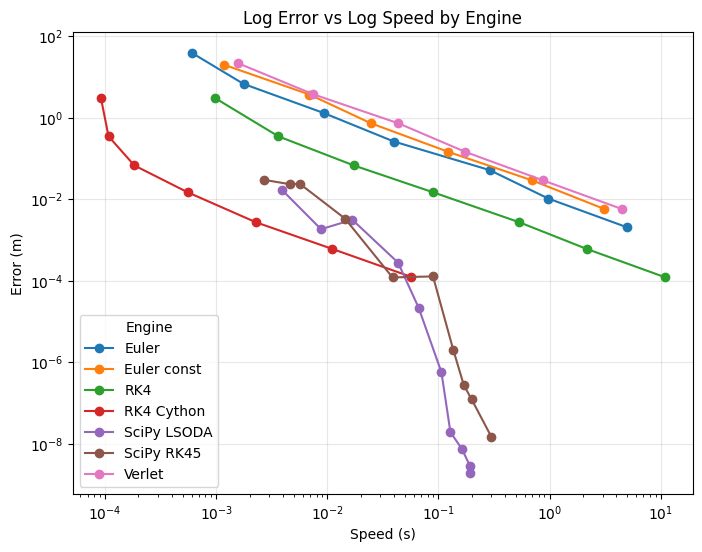

In [21]:
from matplotlib import pyplot as plt
dfplot = pd.DataFrame(summary, columns=['Engine', 'Multiplier', 'Error (m)', 'Integration Steps', 'Speed'])
fig, ax = plt.subplots(figsize=(8, 6))
for engine, group in dfplot.groupby('Engine'):
    ax.plot(group['Speed'], group['Error (m)'], marker='o', label=engine)
ax.set_xlabel('Speed (s)')
ax.set_ylabel('Error (m)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Log Error vs Log Speed by Engine')
ax.legend(title='Engine')
ax.grid(True, which='major', alpha=0.3)
plt.show()

## Data

In [22]:
display(dfplot.style.format({'Multiplier': '{:.10f}', 'Error (m)': '{:.12f}'}))

,Engine,Multiplier,Error (m),Integration Steps,Speed
0,SciPy RK45,0.0000000001,0.000000015108,8702,0.299046
1,SciPy RK45,0.0000000010,0.000000125516,7520,0.198652
2,SciPy RK45,0.0000000100,0.000000276307,6722,0.169317
3,SciPy RK45,0.0000001000,0.000002057640,5156,0.135883
4,SciPy RK45,0.0000010000,0.000127843121,3080,0.089423
5,SciPy RK45,0.0000100000,0.000120657467,1448,0.038640
6,SciPy RK45,0.0001000000,0.003347521269,512,0.014426
7,SciPy RK45,0.0010000000,0.024012462772,176,0.005635
8,SciPy RK45,0.0100000000,0.023207585512,110,0.004622
9,SciPy RK45,0.1000000000,0.029732142680,68,0.002697
